In [176]:
#Import Stuff
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15,10)

# Errors

Here we will look at error calculations. The book covers the same material in chapter 8 in a slightly different way. I think this is the most simple way to understand error, it also gives us a tiny peak into time series calculations - or situations where we have a dataset that is a series of values. 

Error is critically important as we move into inferential statistics and eventually into machine learning. We are generating predictions, so we need some way to objectively evaluate how accurate we can expect those predictions to be. Calculating error allows us to put a number on the accuracy of a model. If we remember back to some of the data that we used last time, we saw our first peek at errors when looking at regression lines. 

<b>Note:</b> The linregress function can be pretty much ignored for now, we are just using it to get the slope and intercept. We'll dig into this more in a few weeks, for now it is just a shortcut. 

Slope: 0.00841410925029914
Intercept: -0.11344794979746348
Equation:  y= 0.00841410925029914 * x + -0.11344794979746348


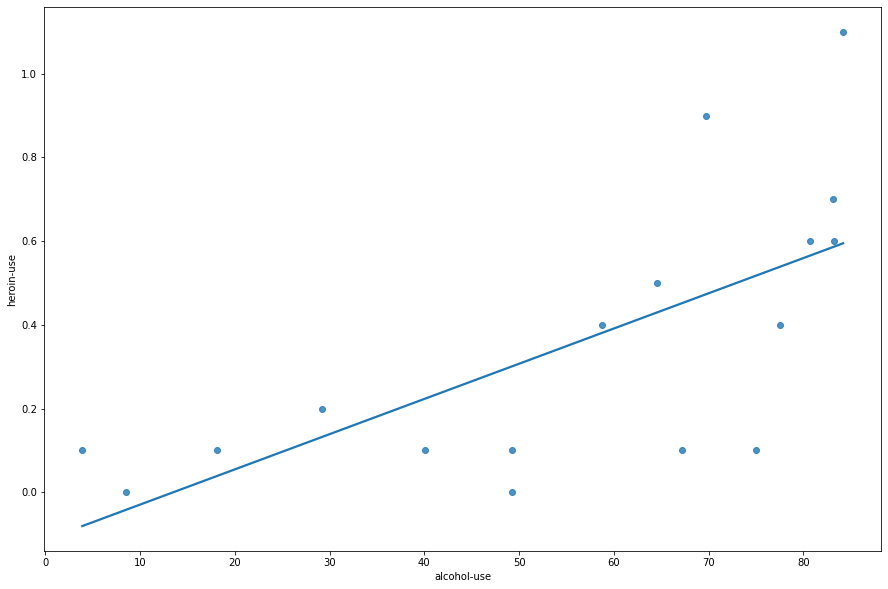

In [177]:
drg = pd.read_csv("data/drug-use-by-age.csv")
sns.regplot(data=drg, x="alcohol-use", y="heroin-use", dropna=True, ci=0)
slope, intercept, r_value, pv, se = ss.linregress(drg["alcohol-use"], drg["heroin-use"])
print("Slope:", slope)
print("Intercept:", intercept)
print("Equation:  y=", slope, "* x +", intercept)

#### Highlight Errors

Each error is the distance, in the y direction*, that the model is from each point. 

The regression line is a model - an analytical representation of real data. The model (the line) serves as our prediction - "for an X value of _____, we expect a Y value of _______", where that y value is the Y value of the model at X. Our model isn't perfect, for the values around 10-30, the model and the real data look to be very close, so a prediction from the model and the real value are virtually identical. For values around 40-50, there is a much larger separation - the model delivers predictions that are different from the emperical data. This vertical difference is the error, the closer the model is to the data, the less error there is, or the better it "fits". 

![Errors](images/error_size.png)

*The "in the y direction" part is due to the X-Y variable choice and the convention of how we write functions. Here X is independent varaible, Y is the dependent, so the form of the line is y = m * X + b, a.k.a "y is a function of X". What this means is that we provide an X (or several X's in larger scenarios), and we predict a Y. So since we are predicting Y, we measure our error with respect to Y. 

<b>Note:</b> This is actually a really simple example of a machine learning model, and this error calculation is identical. 

## Data - Time Series

Our data is a list of gas prices - the average of several gas stations in one city. We have 30 days of data. If our goal is to predict the price on day 31 we have several ways we could do it - this is time series analysis that we'll look at a bit more later. For now, we'll look at the most simple way - take an average. 

My simple algorithm for predicting the next day's gas price will simply average together the previous 5 days of data, and that will be the prediction for the next day. This is kind of what we do in lots of situations - how much will a bake sale yeild? How long will it take to drive to Calgary? How many people will be ahead of me in line at Starbucks? We can average the previous few values together and use that as a projection. There obviously are more advanced ways to predict this, for now we'll use this simple way because we are just looking for error. 

#### What's a Time Series?

This data is a time series, or data that progresses over time (day by day, year by year, hour by hour, etc...) Time series data is something that we'll touch on a little more later, and into ML. Dealing with time series data is somewhat different that other data when we get into predictive modelling. Here, all we need to care about is our model(s), the real data, and how much they differ. 

In [178]:
df = pd.read_csv("data/GasTimeSeries.csv")
df.head()

,Day,Price
0,1,1.48
1,2,1.51
2,3,1.49
3,4,1.46
4,5,1.42


In [179]:
#Average together last 5 values. 
avg5 = df["Price"].tail(5).mean()
avg5

1.468

Now, we have a projected value for tomorrow. However, what if my friend says "averaging 5 days is silly, I'm going to only use the past 3!"

This will give us two separate models - they each do the same thing, but they were each calculated differently, and will yeild different results. We can explore their error to try to determine which is better. 

In [180]:
#Average together last 3 values. 
avg3 = df["Price"].tail(3).mean()
avg3

1.4400000000000002

### Evaluating Predictions

Ok, now we both have predictions for the price on day 31, but who's prediction is more accurate? We have no idea. 

The way that we can evaluate predictions against eachother is by running trials where we know the answer, and comparing our prediction to real values. This basic idea holds true for the machine learning stuff we do later on. The generallized process is:

- Use some algorithms to create some models that make predictions.

- Use those models on some old (test) data, where we know the actual, real outcome.

- Compare our predictions to those known values - the closer we are, the more accurate that model is. 

- Choose the most accurate (usually - there's sometimes other factors) model, as its predictions are the best.



So, for our gas price scenario here:

- We have two models - a 3 day average and a 5 day average. We could have more, including sophisticated ones.

- Run our old (test) data through the models to generate a prediction. We also know the correct values for these predictions.

- For each prediction, calculate how wrong it is - the error. (Aka the residual).

- Tally up the errors to a single metric of error. 

In [181]:
#Add old predictions
#Note: to figure out the command I Googled "dataframe moving average" and got the rolling function
df["avg5"] = df["Price"].rolling(5, closed="left").mean()
df["avg3"] = df["Price"].rolling(3, closed="left").mean()
df.head(10)

,Day,Price,avg5,avg3
0,1,1.48,NaN,NaN
1,2,1.51,NaN,NaN
2,3,1.49,NaN,NaN
3,4,1.46,NaN,1.493333
4,5,1.42,NaN,1.486667
5,6,1.48,1.472,1.456667
6,7,1.59,1.472,1.453333
7,8,1.61,1.488,1.496667
8,9,1.53,1.512,1.560000
9,10,1.51,1.526,1.576667


If we look at the line for day 6:

- The real value is 1.48.

- The 5 day model predicts 1.472.

- The 3 day model predicts 1.457. 

So the 5 day model is off by .08, while the 3 day model is off by .23 - apx three times as much error. 

Every one of these old predictions will have an error like this, we can populate them in the table.

In [182]:
#Calculate the residuals (errors) and put them into the table
df["res5"] = df["Price"]-df["avg5"]
df["res3"] = df["Price"]-df["avg3"]
df.head(10)

,Day,Price,avg5,avg3,res5,res3
0,1,1.48,NaN,NaN,NaN,NaN
1,2,1.51,NaN,NaN,NaN,NaN
2,3,1.49,NaN,NaN,NaN,NaN
3,4,1.46,NaN,1.493333,NaN,-0.033333
4,5,1.42,NaN,1.486667,NaN,-0.066667
5,6,1.48,1.472,1.456667,0.008,0.023333
6,7,1.59,1.472,1.453333,0.118,0.136667
7,8,1.61,1.488,1.496667,0.122,0.113333
8,9,1.53,1.512,1.560000,0.018,-0.030000
9,10,1.51,1.526,1.576667,-0.016,-0.066667


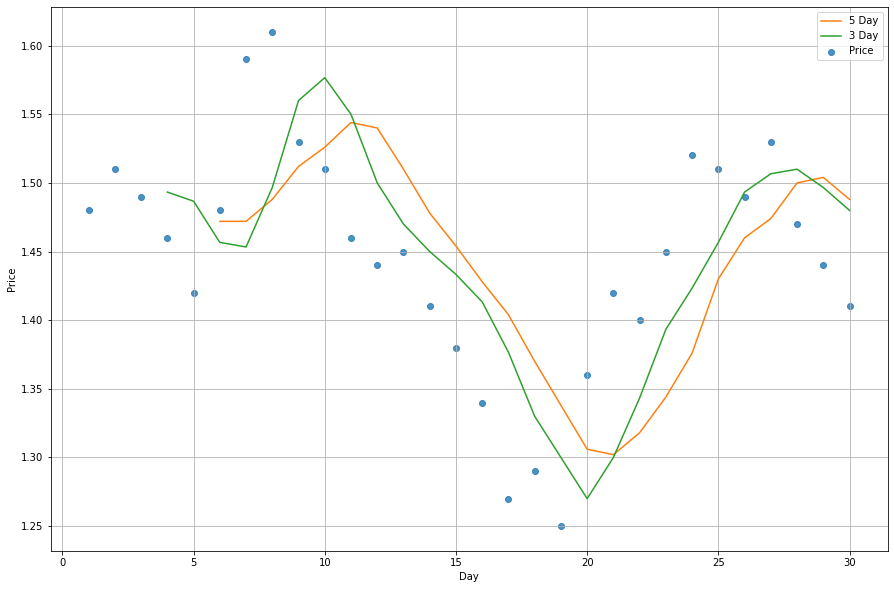

In [183]:
#Graph them to take a look
sns.regplot(x="Day", y="Price", data=df, label="Price", fit_reg=False)
sns.lineplot(x="Day", y="avg5", data=df, label="5 Day")
sns.lineplot(x="Day", y="avg3", data=df, label="3 Day")
plt.legend()
plt.grid()
plt.show()

#### Graphing Results

On the plot we can see the emperical data, as well as our model. Since our models are both just averages of "the last X days", each seems to be a delayed shape of the emperical data. We can also see the error amounts visually on the graph very easily. The line is the real data, and the sets of dots are the models that we've created that model that data (and that could be used to look forward to make predictions.)

The error is simply the gap between the real value and the model's value. For example, around day 26, the 3 Day Rolling Average model delivers a nearly perfect prediction - there is near 0 error. On day 11, both models deliver predictions that have lots of error, each one is approximately .10 too high. 

In [184]:
df[df["Day"] == 26]

,Day,Price,avg5,avg3,res5,res3
25,26,1.49,1.46,1.493333,0.03,-0.003333


In [185]:
df[df["Day"] == 11]

,Day,Price,avg5,avg3,res5,res3
10,11,1.46,1.544,1.55,-0.084,-0.09


### Exploring the Residuals

If we look at the two residual columns we can make some sense of it. If one model has smaller residuals, it is more accurate. 

It isn't really practical to use a massive column of errors, especially with a real amount of data, so we have ways to aggregate these individual errors into total metrics. For example, we can average all the errors together:

In [186]:
df[["res5", "res3"]].mean()

res5   -0.001120
res3   -0.004815
dtype: float64

This way is pretty dumb though, since if we predict 5c too high one time, and 5c too low another, that will average out to no error - obviously not really a good calculation in most cases. What if we take the absolute values, to remove that issue?

In [187]:
df[["res5", "res3"]].abs().mean()

res5    0.076000
res3    0.061852
dtype: float64

This does a better job, but...

### Error Metrics and MSE

Better, a more realistic estimate of the error. 

In most cases however, we don't use the absolute value to deal with negatives, we use squaring. There are a few reasons for this:

- Simple: small errors are 'penalized' less than large errors when squaring. 

- Lazy: it is extremely common, well understood, and implemented all over the place. 

- Mathy: absolute value calculations generally suck when doing real math. Squaring gives the most 'efficient' estimation of errors - you need the smallest number of values to create an estimate, for math reasons we really don't care about: https://en.m.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem

We can calculate a common error metric, MSE - mean squared error. Which is just what it sounds like. 

In [188]:
df[["res5", "res3"]].pow(2).mean()

res5    0.007084
res3    0.004879
dtype: float64

Another very common error metric is RMSE - root mean squared error, which is just the square root of the MSE

In [189]:
#Calculate RMSE
e5, e3 = df[["res5", "res3"]].pow(2).mean()
np.sqrt(e5), np.sqrt(e3)

(0.0841674521415494, 0.06985287301401968)

#### RMSE

Similarly to how we usually translate variance to standard deviation, we usually translate MSE to RMSE. RMSE is in the "same terms" as the original data, we can think of it as rougly the expected amout of error in a typical prediction. 

For our purposes, going forward into machine learning, we are usually looking at error as our "score" - we want to create models that have less error, so their predictions are closer to reality, so we can rely on our predictions with more confidence. 

##### Results

So, for these calculations the 3 day average model is more accurate with our data. With new data, there's no assurance that it will continue to be more accurate, but based on the data we have, we can trust it more. The more old (training) data we have, the more robust these error caclulations will generally be. 

We don't need to do this by hand, there are existing functions that do it for us...

In [190]:
#Calculate RMSE using prebuilt functions. Hopefully the results are the same!!
from sklearn.metrics import mean_squared_error
# real value
expected = df["Price"]
#Note: The iloc thing selects the rows. The function can't deal with missing values.
# predicted value
predicted5 = df["avg5"].iloc[5:]
predicted3 = df["avg3"].iloc[3:]
# calculate errors. Change squared to True to get MSE
errors5 = mean_squared_error(expected.iloc[5:], predicted5, squared=False)
errors3 = mean_squared_error(expected.iloc[3:], predicted3, squared=False)
errors5, errors3

(0.08416745214154939, 0.06985287301401968)

### Errors - MSE and RMSE

There are a lot of different ways to calculate the error, RMSE is probably the one that matters most for use, MSE is also used/seen sometimes. 

<b>Note:</b> MSE and RMSE can be really impacted by outliers. Think about why. Another common error measure - mean absolute error tends to be less impacted by outliers. Think about why. 

The basic idea of every error cacluation is just like this simple example - what is the prediction, what is the expected value, how much do they differ, how do we aggregate those differences into a value. (Classification errors are different, we'll worry about that later)

## Exercise for You!!

We can try to calculate a new error metric - we want to replace the squaring in the RMSE error with a power to the 4. So instead of squaring the residuals, then later taking the square roots, we'll take the residuals to a power of 4, then later take the 4th root.

We will call our new error metric - RM4E - root mean 4th'd error. Rolls off the tongue. 

### Challenge

Use the line of best fit from the alcohol vs heroin chart above as the prediction. For this prediction, calculate:
<ul>
<li> The Mean 4th Error - Raise all residuals to the 4th power, and take their mean. Like the squaring in the MSE, except to the 4th rather than the 2nd power. 
<li> The Root Mean 4th Error - The 4th root of the M4E calculated above.
<li> <b>Q:</b> What would happen if we did this to the power of 3 rather than 4?
<li> <b>Q:</b> What are the impacts of doing this, vs the normal squaring?
<li> <b>Q:</b> Are there any scenarios where this might be useful?
</ul>

Recall, the slope and intercept are already calculated above. 

In [191]:
d2 = drg[["alcohol-use", "heroin-use"]]
d2.head()

,alcohol-use,heroin-use
0,3.9,0.1
1,8.5,0.0
2,18.1,0.1
3,29.2,0.2
4,40.1,0.1


#### Generate Predictions from Model

I will add a column that  is the prediction for each row. Recall, the prediction is the line of best fit that we generated above, or y = slope*x + intercept. We have the slope and intercept from above, so we can plug each x in to calculate the prediction from that formula. 

In [192]:
d2["pred"] = slope*d2["alcohol-use"]+intercept
d2.head()

,alcohol-use,heroin-use,pred
0,3.9,0.1,-0.080633
1,8.5,0.0,-0.041928
2,18.1,0.1,0.038847
3,29.2,0.2,0.132244
4,40.1,0.1,0.223958


#### Plot Prediction to Check

I will plot my data, along with the predictions, to make sure that things look realistic before going forward. This isn't required, it is just a check. If the plot showed data that didn't overlap, we'd know somehting has gone wrong. 

<AxesSubplot:xlabel='alcohol-use', ylabel='heroin-use'>

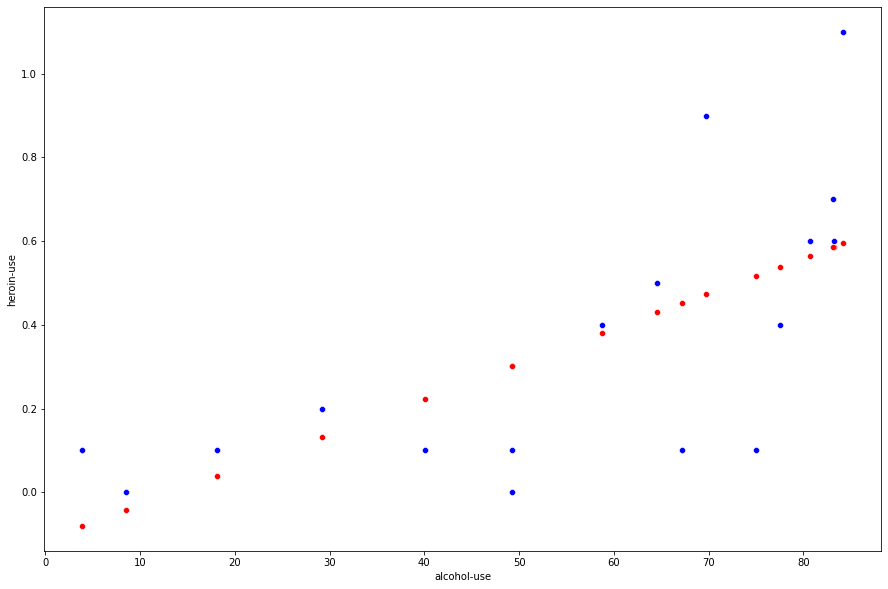

In [193]:
sns.scatterplot(data=d2, x="alcohol-use", y="heroin-use", color="blue")
sns.scatterplot(data=d2, x="alcohol-use", y="pred", color="red")

#### Add Residuals

The predictions look as expected. Now I can calculate the residuals, or the error for each prediction versus the true y value. 

In [194]:
d2["residual"] = d2["heroin-use"]-d2["pred"]
d2.head()

,alcohol-use,heroin-use,pred,residual
0,3.9,0.1,-0.080633,0.180633
1,8.5,0.0,-0.041928,0.041928
2,18.1,0.1,0.038847,0.061153
3,29.2,0.2,0.132244,0.067756
4,40.1,0.1,0.223958,-0.123958


#### Generate Residuals to the 4th

We are calculating the mean of the errors to the 4th power, so I will add a column to raise the residuals to the 4th. 

In [195]:
d2["res4"] = d2["residual"]**4
d2.head()

,alcohol-use,heroin-use,pred,residual,res4
0,3.9,0.1,-0.080633,0.180633,0.001065
1,8.5,0.0,-0.041928,0.041928,0.000003
2,18.1,0.1,0.038847,0.061153,0.000014
3,29.2,0.2,0.132244,0.067756,0.000021
4,40.1,0.1,0.223958,-0.123958,0.000236


#### Calculate Error Totals

We can average, and then 4th root the last column, to get our totals. 

In [196]:
m4e = d2["res4"].mean()
rm4e = d2["res4"].mean()**(1/4)
m4e, rm4e

(0.009166295994124177, 0.3094200623454214)

#### Compare with MSE/RMSE

In [197]:
d2["res2"] = d2["residual"]**2
m2e = d2["res2"].mean()
rm2e = d2["res2"].mean()**(1/4)
m2e, rm2e

(0.05670393991977641, 0.48798144524766557)

## Exercise

<ul>
<li>Calculate a 4 day moving average and a 6 day moving average for the time series data above. 
<li>Which is a more reliable prediction model? Why?
</ul>

In [198]:
# Code here
df.head()

,Day,Price,avg5,avg3,res5,res3
0,1,1.48,NaN,NaN,NaN,NaN
1,2,1.51,NaN,NaN,NaN,NaN
2,3,1.49,NaN,NaN,NaN,NaN
3,4,1.46,NaN,1.493333,NaN,-0.033333
4,5,1.42,NaN,1.486667,NaN,-0.066667


<b>Too Easy? Try to build a rm4e function, that can return the error given a dataset.</b>